In [1]:
import torch
import cv2
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import math

# # local files
sys.path.insert(0, '../')
import pyClient
import utils
import sim_utils
import model
from model import Transition
from testing_laura import test

In [2]:
## Image processing
class ImageProcessor(object):
    def __init__(self, phosphene_resolution=None, imsize=128):

        self.imsize = imsize
        if phosphene_resolution is not None:
            
            #phosphene map is expessed as a map of polar angles and eccentricities.
            ecc_coverage   = 30                # in degrees
            polar_coverage =  2 * math.pi      # in radians

            #number of phosphenes placed at each polar angle.
            phosphenes_per_polar = round(math.sqrt(phosphene_resolution))
            phosphenes_per_ecc   = round(math.sqrt(phosphene_resolution))

            noise_scale = 0.14 #standard deviation of the random noise added to phosphene position

            self.imsize = imsize

            ## STEP 2: Establishing of phosphene simulator
            COEFF = 60 # coefficient used to ajust calculated phosphene size to display pixel size - ajust for optimal display
            eff_activation = 1  #diameter of the area in which neurons are activated - in theory this is in mm
                                #(but it is unclear if mm is accurate-relative changes to area should work as intended) 


            self.simulator = sim_utils.PhospheneSimulator(ecc_coverage, 
                                                          polar_coverage, 
                                                          phosphenes_per_polar, 
                                                          phosphenes_per_ecc, 
                                                          noise_scale, 
                                                          coeff = COEFF, 
                                                          eff_activation = eff_activation,
                                                          windowSize = imsize)
        else: 
            self.simulator = None
    
    def __call__(self,state_raw, memory_trace):
        frame = environment.state2usableArray(state_raw)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.astype('float32')
   
        if self.simulator is not None:
            frame, memory_trace = self.simulator(frame, memory_trace)
    
      
        return torch.Tensor(frame / 255.).view(1,1,self.imsize, self.imsize), memory_trace
    
    def count_phosphenes(self):
        if self.simulator is not None:
            getphos = getattr(self.simulator, 'phosphenes')
            count = len(getphos)
        else:
            count = 0
        return count
        
    
img_processing = ImageProcessor

In [3]:
# Environment parameters
IMSIZE = 128
STACK_SIZE = 4
N_ACTIONS = 3
IP  = "127.0.0.1" # Ip address that the TCP/IP interface listens to
PORT = 13000       # Port number that the TCP/IP interface listens to

environment = pyClient.Environment(ip = IP, port = PORT, size = IMSIZE) 

# Model parameters
BATCH_SIZE = 2 #original 128
#DEVICE = 'cuda:0'
DEVICE = 'cpu'

agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 device=DEVICE)


## Testing parameters 
RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                         1:False,   # Box collision
                         2:False,   # Wall collision
                         3:True}  # Reached step target
RESET_AFTER_NR_SIDESTEPS = 5


# Testing configuration dictionary
cfg = dict()
cfg['stack_size']               = STACK_SIZE
cfg['reset_after_nr_sidesteps'] = RESET_AFTER_NR_SIDESTEPS
cfg['reset_upon_end_signal']    = RESET_UPON_END_SIGNAL

test_data = []
for seed in [0,1,2,3,4]:
    for complexity in ['plain', 'complex']:
        for phosphene_resolution in [None, 10, 100, 1000]:
            
            # Condition-specific configuration
            cfg['training_condition']       = 2 if complexity == 'plain' else 3 # 0: plain training, 1: complex training, 2: plain testing 3: complex testing
            model_name = 'Exp_Laura_{}_phos{}_S{}'.format(complexity, phosphene_resolution,seed)
            model_path = 'Out/Exp_Laura/{}_best_model.pth'.format(model_name)
            print(model_name)
            
            # Phosphene simulation
            img_processing = ImageProcessor(phosphene_resolution = phosphene_resolution)
            
            #Memory trace parameters
            theta = 0 #Lower bound; represents something like a minimal electrode current to elicit phosphene
            decay = 0.9 #decay rate of memory
            decay_activation = 0.05 #decay of activation
            input_effect = 0.75 #effect of new input on image
            trace_increase = 0.4 #effect of new input on memory trace
            
            n_phosphenes = img_processing.count_phosphenes()
            #total_phosphenes = getattr(img_processing.simulator, 'phosphenes')
            #n_phosphenes = len(total_phosphenes) #number of phosphenes

            #Establish Memory Trace
            memory_trace = sim_utils.Memory(theta, decay, decay_activation, input_effect, trace_increase, n_phosphenes)

            

            # Re-initialize model and optimizer
            agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 device=DEVICE)
            agent.policy_net.load_state_dict(torch.load(model_path,map_location=DEVICE))
            
            # Start training
            #training_laura.train(agent, environment, img_processing, optimizer, memory_trace, cfg)
            #print('finished training')

            # Testing
            conditions = {'complexity': complexity, 'phosphene_resolution': phosphene_resolution, 'seed' : seed}
            results = test(agent, environment, img_processing, memory_trace, cfg)
            test_data.append({**conditions,**results})
data = pd.DataFrame(test_data)
data.to_csv('Out/Exp_Laura/_test_results.csv', index=False)

Exp_Laura_plain_phosNone_S0
Exp_Laura_plain_phos10_S0


..\sim_utils.py:159: RuntimeWarning: invalid value encountered in true_divide
  I = np.sum(image_filtered[y-halfs:y+halfs, x-halfs:x+halfs]) / np.power(s,2) #current used for simulation


Exp_Laura_plain_phos100_S0
Exp_Laura_plain_phos1000_S0
Exp_Laura_complex_phosNone_S0
Exp_Laura_complex_phos10_S0
Exp_Laura_complex_phos100_S0
Exp_Laura_complex_phos1000_S0
Exp_Laura_plain_phosNone_S1
Exp_Laura_plain_phos10_S1
Exp_Laura_plain_phos100_S1
Exp_Laura_plain_phos1000_S1
Exp_Laura_complex_phosNone_S1
Exp_Laura_complex_phos10_S1
Exp_Laura_complex_phos100_S1
Exp_Laura_complex_phos1000_S1
Exp_Laura_plain_phosNone_S2
Exp_Laura_plain_phos10_S2
Exp_Laura_plain_phos100_S2
Exp_Laura_plain_phos1000_S2
Exp_Laura_complex_phosNone_S2
Exp_Laura_complex_phos10_S2
Exp_Laura_complex_phos100_S2
Exp_Laura_complex_phos1000_S2
Exp_Laura_plain_phosNone_S3
Exp_Laura_plain_phos10_S3
Exp_Laura_plain_phos100_S3
Exp_Laura_plain_phos1000_S3
Exp_Laura_complex_phosNone_S3
Exp_Laura_complex_phos10_S3
Exp_Laura_complex_phos100_S3
Exp_Laura_complex_phos1000_S3
Exp_Laura_plain_phosNone_S4
Exp_Laura_plain_phos10_S4
Exp_Laura_plain_phos100_S4
Exp_Laura_plain_phos1000_S4
Exp_Laura_complex_phosNone_S4
Exp_Laura_c

In [4]:
test_data = pd.read_csv('./Out/Exp_Laura/_test_results.csv') 
test_data

,complexity,phosphene_resolution,seed,wall_collisions,box_collisions,endless_loops,step_count,cumulative_reward
0,plain,NaN,0,458,8,93,565,-3871
1,plain,10.0,0,479,8,96,576,-4071
2,plain,100.0,0,407,10,80,526,-3422
3,plain,1000.0,0,449,8,88,548,-3773
4,complex,NaN,0,446,16,92,559,-3964
5,complex,10.0,0,462,15,95,571,-4101
6,complex,100.0,0,460,16,94,571,-4102
7,complex,1000.0,0,359,20,80,512,-3232
8,plain,NaN,1,262,21,59,441,-2263
9,plain,10.0,1,341,10,49,458,-2749


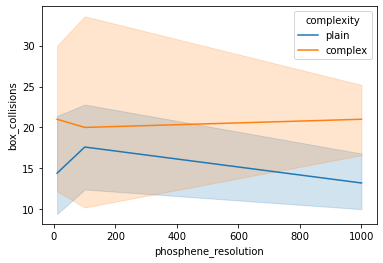

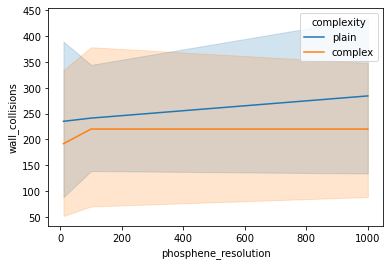

<AxesSubplot:xlabel='phosphene_resolution', ylabel='cumulative_reward'>

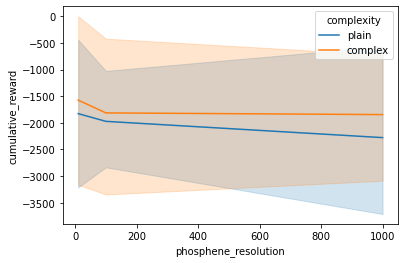

In [5]:
sns.lineplot(data=test_data,x='phosphene_resolution', y='box_collisions', hue='complexity')
plt.show()
sns.lineplot(data=test_data,x='phosphene_resolution', y='wall_collisions', hue='complexity')
plt.show()
sns.lineplot(data=test_data,x='phosphene_resolution', y='cumulative_reward', hue='complexity')

In [7]:
### Training and validation curves

all_stats = pd.DataFrame()
best_stats = pd.DataFrame()
for complexity in ['plain', 'complex']:
    for phosphene_resolution in [None, 10,100,1000]:
        for seed in [0,1,2,3,4]:
            model_name = 'Exp_Laura_{}_phos{}_S{}'.format(complexity, phosphene_resolution,seed)
            train_csv = './Out/Exp_Laura/{}_train_stats.csv'.format(model_name)
            train_stats = pd.read_csv(train_csv)
            train_stats['complexity'] = complexity
            train_stats['resolution'] = phosphene_resolution
            train_stats['seed'] = seed
            train_stats['model_name'] = model_name
            
            # append all rows
            all_stats = all_stats.append(train_stats,ignore_index=True)
            
            # append only best-performing validation row
            val = train_stats.loc[train_stats.validation==1].reset_index()
            best_stats = best_stats.append(val.iloc[[val.reward.idxmax()]], ignore_index=True)


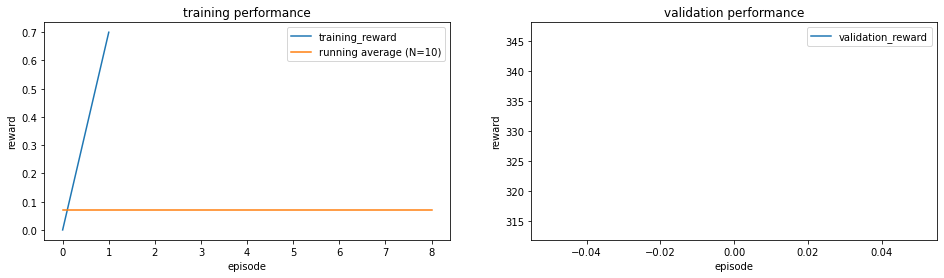

In [8]:
MODEL_NAME = 'Exp_Laura_plain_phos100_S2'

stats = all_stats.loc[all_stats.model_name==MODEL_NAME]

plt.figure(figsize = (16,4))
plt.subplot(1,2,1)
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='reward')
plt.plot(np.convolve(stats.loc[stats.validation==0].reward,np.ones(10)/10,mode='valid'))
plt.title('training performance')
plt.legend(['training_reward', 'running average (N=10)'])
plt.subplot(1,2,2)
sns.lineplot(data= stats.loc[stats.validation==1],x='episode', y='reward')
plt.title('validation performance')
plt.legend(['validation_reward'])
plt.show()

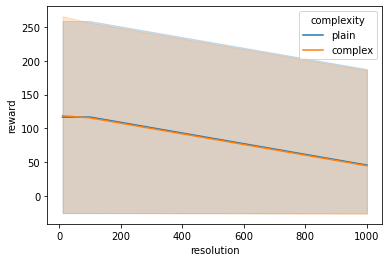

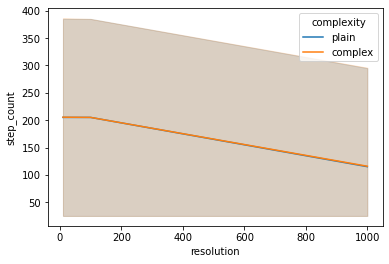

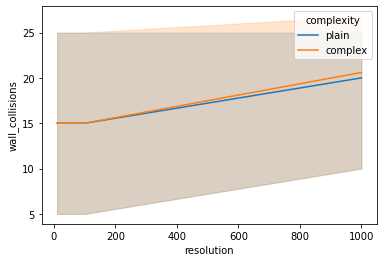

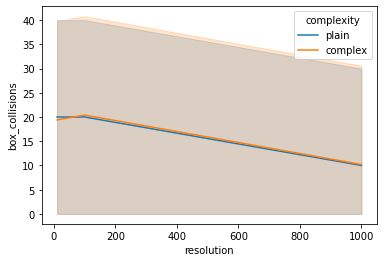

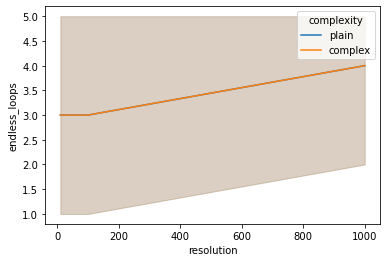

In [9]:
for y in ['reward', 'step_count', 'wall_collisions', 'box_collisions', 'endless_loops']:
    sns.lineplot(data=best_stats, x='resolution',y=y,hue='complexity')
    plt.show()